In [ ]:
# default_exp patrones_espacio_temporales

In [ ]:
# export
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from criminologia_cdmx.etl import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# patrones_espacio_temporales

> Métodos para explorar los patrones espacio-temporales de la delincuencia y su evolución

* https://doi.org/10.1080/13658816.2017.1406943

## kde2D

## ajusta_bandwidth_kde

In [ ]:
# exports
def ajusta_bandwidth_kde(x, y, bandwidth_space, xbins=100j, ybins=100j, n_jobs=-1, **kwargs):
    """Regresa el valor de bandwidth con mejor log likelihood.

    Parametros:
    x, y: np.array con las coordenadas x y y de los puntos
    bandwith_space: np.linspace con el espacio de búsqueda
    xbins, ybins: complejos de numpy con el número de bins en x y y

    """

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins,
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T
    grid = GridSearchCV(KernelDensity(metric='haversine'), bandwidth_space, n_jobs=n_jobs)
    grid.fit(xy_train)
    return grid.best_estimator_.bandwidth

In [ ]:
carpetas = get_carpetas_from_api(1000)
x = carpetas.geometry.x.to_numpy()
y = carpetas.geometry.y.to_numpy()
params = {'bandwidth': np.linspace(0.001, 0.1, 100)}
bw = ajusta_bandwidth_kde(x, y, params)
print(bw)

0.009000000000000001


## kde2D

In [ ]:
# export
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j):
    """Regresa una matriz con la densidad de kernel para los puntos x,y.

    Parametros:
    x, y: np.array con las coordenadas x y y de los puntos
    bandwith: ancho del kernel gaussiano
    xbins, ybins: complejos de numpy con el número de bins en x y y

    """

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins,
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, metric='haversine')
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

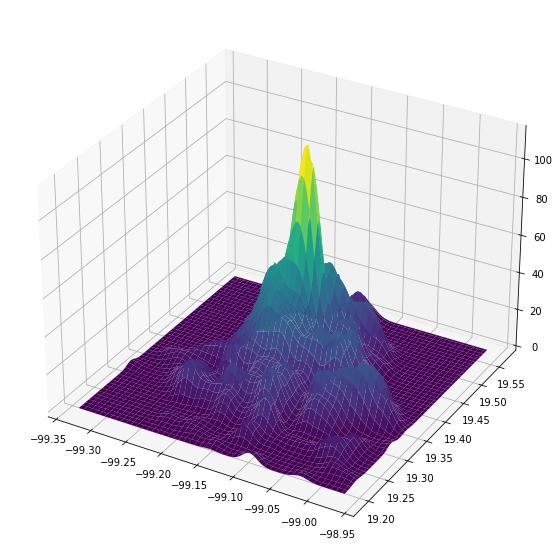

In [ ]:
xx, yy, zz = kde2D(x, y, bw, xbins=100j, ybins=100j)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, zz,cmap='viridis', edgecolor='none')

## serie_tiempo_kde_categoria

In [ ]:
# export
def serie_tiempo_kde_categoria(carpetas, fechas, categorias, offset,
                               grid_search={'bandwidth': np.linspace(0.001, 0.1, 20)},
                               bw=None,
                               **kwargs):
    """Ajusta kdes egregando los datos sobre cada categoria e intervalo de fecha.

       parameters:
       carpetas: Las carpetas de investigación (preprocesadas)
       fechas: lista de fechas con los extremos de los intervalos
       categorias: Lista de categorías para calcular el KDE
       offset: intervalo para agregar antes de la primera fecha, p.ej: "30 days" si los intervalos son mensuales
       grid_search: {'bandwidth': np.linspace(0.001, 0.1, 100)} valores para ajustar el bandwidth (se usa sólo si bandwidth es nulo)
       bandwidth: Si no se especifica grid_search, se tiene que dar un valor de bandwidth
       **kwargs: argumentos extra que se pasan a `kde2D`

       returns:
       (xx, yy) [zz]: la tupla (xx, yy) es el grid común de los kdes, la lista contiene los valores de z para cada intervalo
    """
    kdes = []
    fecha_inicio = fechas[0] - pd.to_timedelta(offset)
    for i, fecha in enumerate(fechas):
        if i == 0:
            datos_intervalo = carpetas.loc[(carpetas['fecha_hechos'].between(pd.to_datetime('1/1/2017'), fecha, inclusive='left')) &
                                           (carpetas['categoria'].isin(categorias))]
        else:
            datos_intervalo = carpetas.loc[(carpetas['fecha_hechos'].between(fechas[i-1], fecha, inclusive='left')) &
                                           (carpetas['categoria'].isin(categorias))]
        x = datos_intervalo.geometry.x.to_numpy()
        y = datos_intervalo.geometry.y.to_numpy()
        if bw is None:
            bw = ajusta_bandwidth_kde(x, y, grid_search)
        xx, yy, zz = kde2D(x, y, bw, **kwargs)
        kdes.append(zz)
    return xx, yy, kdes

In [ ]:
carpetas = get_historico_carpetas()
carpetas = agregar_categorias_carpetas(carpetas)
fechas = pd.date_range(start='1/1/2019', end='3/1/2019', freq='M').to_list()
xx, yy, kdes = serie_tiempo_kde_categoria(carpetas, fechas, ["Homicidios dolosos"], "30 days", bw=0.001)
assert type(kdes[0]) == np.ndarray

## serie_razones_de_eventos

In [ ]:
# export
def serie_razones_de_eventos(carpetas, fechas, categoria, offset, **kwargs):
    """Regresa el mapa de razón entre una categoría con respecto a las demás."""
    xx, yy, kdes_categoria = serie_tiempo_kde_categoria(carpetas, fechas, [categoria], offset, **kwargs)
    categorias_todas = list(carpetas[carpetas.categoria.notnull()]['categoria'].unique())
    categorias_todas.remove(categoria)
    xx, yy, kdes_base = serie_tiempo_kde_categoria(carpetas, fechas, categorias_todas, offset, **kwargs)
    # TODO: vectorizar esta operación np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    serie_razones = [np.divide(np.round(e, 5), np.round(b, 5), out=np.zeros_like(e), where=np.round(b, 5)!=0) for e, b in zip(kdes_categoria, kdes_base)]
    return serie_razones

````Python
%%time
serie_razones = serie_razones_de_eventos(carpetas, 
                                         fechas, 
                                         "Homicidios dolosos", 
                                         "30 days", 
                                         bw=0.001)
````

## serie_mapas_intensidad

In [ ]:
# export
def serie_mapas_intensidad(carpetas, fechas, categoria, offset, **kwargs):
    """Regresa los mapas de razon y las intensidades de la categoría para las `fechas` seleccionadas."""
    razones = serie_razones_de_eventos(carpetas, fechas, categoria, offset, **kwargs)
    avg = np.round(np.mean(razones, axis=0), 5)
    std = np.round(np.std(razones, axis=0), 5)
    intensidad = [np.divide(r - avg, std, out=np.zeros_like(r), where=std!=0) for r in razones]
    return razones, intensidad

In [ ]:
razones, intensidades = serie_mapas_intensidad(carpetas, 
                                               fechas,
                                               'Homicidios dolosos',
                                               "30 days", bw=0.001)

## p_value_maps

In [ ]:
# export
def p_value_maps(razones):
    """Regresa los mapas de significancia estadística para las razones."""
    p_values = []
    for r in razones:
        comp = [b >= r for b in razones]
        comp = np.sum(comp, axis=0)
        p = comp / (len(razones) + 1)
        p_values.append(p)
    return p_values

In [ ]:
significancias = p_value_maps(razones)